In [27]:
import time

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np

import os, sys

import utils

from best_utils import *
from cross_validation import cross_validation
import image_preprocessing

from skimage import color

import keras

from skimage.color import rgb2hsv

from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, LeakyReLU, Dropout

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
ROOT_DIR = 'training/'
IMAGE_DIR = ROOT_DIR + 'images/'
GT_DIR = ROOT_DIR + 'groundtruth/'

PATCH_SIZE = 16

In [29]:
# Read images, change to hsv, saturate and stack into a tensor
files = os.listdir(IMAGE_DIR)

imgs = np.stack([load_image(IMAGE_DIR + file) for file in files]) # images (400, 400, 3)
gt_imgs = np.stack([load_image(GT_DIR + file) for file in files]) # images (400, 400)

patched_imgs = np.stack([patch_image(img, PATCH_SIZE) for img in imgs]) # images (400, 400)
patched_gts = np.stack([patch_groundtruth(gt, PATCH_SIZE) for gt in gt_imgs])

In [30]:
PATCHED_SIZE = imgs.shape[1] // PATCH_SIZE
WINDOW_SIZE = 71
WINDOWS_PER_IMAGE = PATCHED_SIZE ** 2

In [31]:
N = 5 # Number of image to be used in training

leakyness = 0.1

In [32]:
windows_per_image = [image_to_features(im, WINDOW_SIZE, True) for im in patched_imgs[:N]]
windows = np.vstack(windows_per_image)

window_labels = np.ravel(patched_gts[:N])
assert window_labels.shape[0] == windows.shape[0]

In [33]:
window_cnn = keras.models.Sequential([
    
    Conv2D(32, (5, 5), strides=(1, 1), input_shape=windows.shape[1:]),
    LeakyReLU(leakyness),
    
    MaxPooling2D(2),
    Dropout(0.25),

    Conv2D(64, (3, 3), strides=(1, 1)),
    LeakyReLU(leakyness),
    
    MaxPooling2D(2),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), strides=(1, 1)),
    LeakyReLU(leakyness),
    
    MaxPooling2D(2),
    Dropout(0.25),
    
    Conv2D(256, (3, 3), strides=(1, 1)),
    LeakyReLU(leakyness),

    MaxPooling2D(2),
    Dropout(0.25),
    
    Dense(128),
    LeakyReLU(leakyness),
    
    Flatten(),
    Dense(1, activation='sigmoid'),
    #LeakyReLU(leakyness),
])

In [34]:
window_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 67, 67, 32)        2432      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 67, 67, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 33, 33, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 33, 33, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 31, 31, 64)        18496     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 31, 31, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 64)        0         
__________

In [35]:
window_cnn.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])

In [36]:
nw = windows.shape[0]
def batch_generator():
    while True:
        indices = np.random.choice(range(nw), 200, replace=False)
        yield (windows[indices], window_labels[indices])

In [37]:
def smart_generator(n_windows, n_epochs):
    ws_per_epoch = n_windows // n_epochs
    indices = np.random.choice(range(n_windows), n_epochs*ws_per_epoch, replace=False)
    indices_per_epoch = [indices[i:i+ws_per_epoch] for i in range(0, n_windows, ws_per_epoch)]
    for batch_idx in indices_per_epoch:
        ws = windows[batch_idx]
        labs = window_labels[batch_idx]
        yield (ws, labs)

In [38]:
epochs = 10

In [39]:
start = time.perf_counter()

window_cnn.fit(windows, window_labels, epochs=epochs, batch_size=625)
#window_cnn.fit_generator(smart_generator(windows.shape[0], epochs), steps_per_epoch=windows.shape[0] // epochs, epochs=10)

time.perf_counter() - start

Epoch 1/10
3125/3125 [==============================] - 55s - loss: 0.6231 - acc: 0.7264     
Epoch 2/10
3125/3125 [==============================] - 55s - loss: 0.5905 - acc: 0.7322     
Epoch 3/10
3125/3125 [==============================] - 54s - loss: 0.5885 - acc: 0.7322     
Epoch 4/10
3125/3125 [==============================] - 48s - loss: 0.5863 - acc: 0.7322    
Epoch 5/10
3125/3125 [==============================] - 47s - loss: 0.5852 - acc: 0.7322    
Epoch 6/10
3125/3125 [==============================] - 46s - loss: 0.5862 - acc: 0.7322    
Epoch 7/10
3125/3125 [==============================] - 46s - loss: 0.5836 - acc: 0.7322    
Epoch 8/10
3125/3125 [==============================] - 48s - loss: 0.5831 - acc: 0.7322    
Epoch 9/10
3125/3125 [==============================] - 46s - loss: 0.5865 - acc: 0.7322    
Epoch 10/10
3125/3125 [==============================] - 49s - loss: 0.5878 - acc: 0.7322    


501.44025828899976

In [40]:
from keras import backend as K

In [41]:
K.tensorflow_backend._get_available_gpus()

AttributeError: module 'keras.backend.tensorflow_backend' has no attribute '_get_available_gpus'

# Test on a never seen image

In [ ]:
i = 1

In [ ]:
plt.imshow(imgs[i])

In [ ]:
window_t = image_to_features(patched_imgs[i], WINDOW_SIZE, True)

In [ ]:
preds = window_cnn.predict(window_t)

In [ ]:
f = np.ravel(preds)
f = np.reshape(f, (25, 25))

In [ ]:
plt.plot(np.sort(np.ravel(f)))

In [ ]:
f[f < 0.5] = 0
f[f >= 0.5] = 1

In [ ]:
plt.imshow(patched_gts[i], cmap='Greys_r')

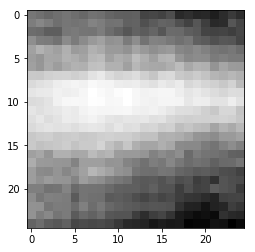

In [25]:
plt.imshow(f, cmap='Greys_r')

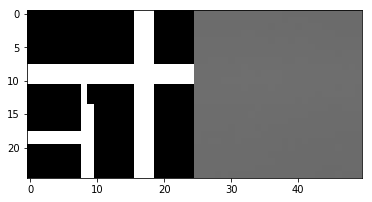

In [26]:
plt.imshow(np.hstack([patched_gts[i], f]), cmap='Greys_r')